In [1]:
import ujson
import numpy 
import datetime

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46


In [5]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

In [6]:
'''We are using all the data from the user from whom we we have previously 
classfied what their primary langauge is '''

isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
#remove Latin because it's not a reliable inference
#TODO for later: get next-best language besides Latin in the inference function
# remove uncommon languages
lang_counts = {}
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] = lang_counts.get(lang, 0) + 1
    ctr+=1
user_langs = {user: lang for user, lang in user_langs.items() if lang!='la' and lang_counts[lang]>=100 and user in summaries}
langset = sorted(list(set(user_langs.values())))
lang_num_map = {lang: i for i, lang in enumerate(langset)} #key is langauge isocode, value is number 
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

lang data created with 43862 users and 18 languages [u'ar', u'ca', u'de', u'el', u'en', u'es', u'fr', u'he', u'it', u'ja', u'ko', u'nl', u'pl', u'pt', u'ru', u'th', u'tr', u'zh']


In [7]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

# Featurizers

## Time featurizer

In [8]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

In [9]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

In [10]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

## Code Features


In [11]:
def deltaDeciles(decileDict, name):
    values = sortDeciles(decileDict)
    deltas = {}
    for i in range(10): 
        if i== 0: pass
        else: deltas[str(i) + " " + name] = values[i]-values[i-1]
    return deltas


def sortDeciles(decileDict):
    deciles_sorted = []
    keys = decileDict.keys()
    for key in keys: 
        deciles_sorted.insert(int(key[-1]), decileDict[key])
    return deciles_sorted



In [12]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [13]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [14]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [15]:
def summaryDeltasTLBlocks(projects): 
    tlblocks = summaryDecileTLBlocks(projects)
    return deltaDeciles(tlblocks, "TL blocks delta")

In [16]:
def summaryDeltasOBlock(projects): 
    oblock = summaryOBlockDecile(projects)
    return deltaDeciles(oblock,"O blocks delta")

In [17]:
def summaryDeltasNumScreens(projects): 
    numscreens = summaryDecileNumScreens(projects)
    return deltaDeciles(numscreens, "numscreens blocks delta")

In [18]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    userDict["NS"] = averageNumStrings(projects) 
    
    #userDict["KW"] = countKeywords(projects)
    
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
    return userDict

### Setup

In [19]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [20]:
def getAllProjects(userID): 
    """list of projects sorted by creation times"""
    projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) #need the sorted for the code features

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])

def getProjects(userID):
    projectlist = getAllProjects(userID)
    return projectlist

In [26]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur', 
              'ru': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'ja': 'asia', 
              'th': 'asia'}
langgroup_num_map = {'eur': 0, 'asia': 1}
def get_user_labels():
    return {user: langgroup_num_map[langgroups[lang]] for user, lang in user_langs.items() if lang in langgroups}

In [27]:
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures,decileProjects])
code_combined = combine_featfuncs([summaryOBlockDecile,summaryDecileTLBlocks,summaryDecileNumScreens,summaryDeltasTLBlocks,summaryDeltasOBlock,summaryDeltasNumScreens, summaryAverages])  

In [28]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

userlabels = get_user_labels()

y = []
ctr = 0
for user in userlabels:
    projects = getProjects(user)  # this returns projects sorted by creation date that include tutorials 
    
    y.append(userlabels[user])
    
    time_features.append(time_combined(projects))
    code_features.append(code_combined(projects))
    
    
    # merge time and code feature dicts
    all_features_user = time_features[-1].copy()
    all_features_user.update(code_features[-1])
    all_features.append(all_features_user)
  
    ctr+=1
    if ctr%1000==0:
        print ctr/1000,
        


y = numpy.array(y)

timevec = DictVectorizer()

Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()

Xall = allvec.fit_transform(all_features)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22


In [29]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Chance is 0.619952494062
Building a logreg model with 22 time
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


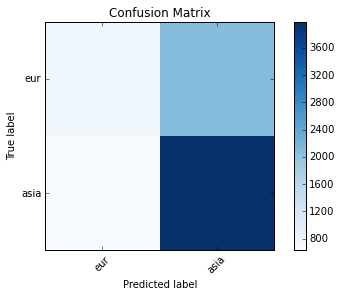

Average accuracy 0.643032912635
Building a logreg model with 69 code
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


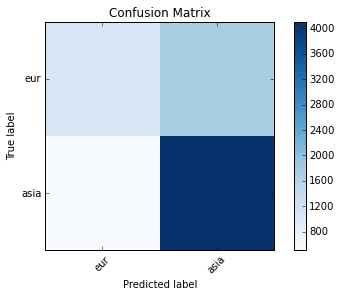

Average accuracy 0.697261712918
Building a logreg model with 91 all
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


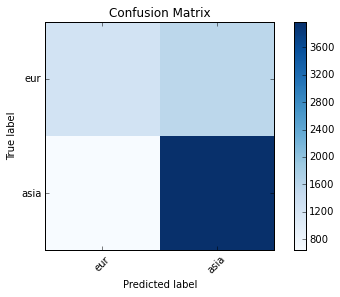

Average accuracy 0.706717943076


In [31]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix

print 'Chance is', max(numpy.bincount(y))/float(len(y))


foldindices = StratifiedKFold(y)

labels = map(lambda x:x[0], sorted(langgroup_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression())]  # no knn because it's too slow 
#multi_class='multinomial', 
                                                             

for modelname, model in classifiers:
    for featname, X in [('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
        
            predictions = model.predict(Xtest)
            #cvf1[i] = f1_score(ytest, predictions)
            
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        
        print 'Average accuracy', numpy.mean(cvaccs)